<center>

## <font color='blue'>ASTR 21100</font>
<center>

### <font color='blue'>"Computational Techniques in Astrophysics"</font>
    
<center>
    
### <font color='blue'>Computing distances to distant galaxies, quasars, and supernovae</font>

<center>
    
### <font color='blue'> 30 points (+ 5 possible extra-credit points)</font>
    
    
<center>

### <font color='blue'> Due Thursday,  Jan 23, 10pm</font>



### Introduction

You probably heard that our Universe expands. We know this because we see that almost all galaxies and quasars are moving away from us - the motion that is reflected in the spectral shift of the lines in their spectra towards longer wavelengths (redder light). The spectral shift (called *redshift*) is defined as $z = (\lambda - \lambda_{\rm lab})/\lambda_{\rm lab}$, where $\lambda_{\rm lab}$ is the wavelength of a line that we would measure in the lab here on Earth and $\lambda$ is the wavelength at which the line is observed in the spectrum of a galaxy or quasar.

Models of the expansion based on Einstein's theory of general relativity predict how the distance to a galaxy $d_L$ depends on redshift $z$. The distance $d_L$ also depends on the Hubble "constant" $H_0$ that characterizes the rate of expansion currently and on the contents of the Universe - the mean density of matter and energy that are expressed in the dimensionless quantities $\Omega_{\rm m0}$ and $\Omega_\Lambda$ defined relative to a reference density. 

In this homework you will implement and test a function that estimates an integral of input function $f(x)$ for the interval $[a,b]$ with the accuracy that is controlled by the input thresholds $\rm atol$ and $\rm rtol$ for absolute and relative accuracy of the estimate (exercise 1). You can do this by modifying a provided function implementing Romberg integration calculation using recursive function calls. In the process you should learn how the accuracy control works in such algorithms and understand what $\rm atol$ and $\rm rtol$ arguments of many package functions do. 

If you would like more challenge, try implementing Romberg integration on your own without using recursive calls. 

You will then test your function by using it to compute distance $d_L$ and compare result to the output of AstroPy's function computing $d_L$ in the exercise 2. 

In the exercise 3, you will use the $d_L$ function to produce figure similar to the figure 
from the paper by <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...746...85S/abstract">Suzuki et al. 2012</a> below, which uses many observational samples of <a href="https://en.wikipedia.org/wiki/Type_Ia_supernova">type Ia supernovae</a>. You will examine how the theoretical line in this figure depends on the absolute magnitude (intrinsic brightness) of these supernovae and on the parameters $\Omega_{\rm m0}$ and $\Omega_\Lambda$. 

If you are not familiar with these concepts, it will be useful if you review [Section 8.1](https://astro.uchicago.edu/~andrey/classes/a211w24/html/appendix/astro.html) of the notes. Please do not hesitate to ask for clarification, if something is not clear. 


<br>
<center><img width=500 src="https://astro.uchicago.edu/~andrey/classes/a211/img/suzuki_etal12_hubble_diagram.png"></img></center>

Import NumPy and Matplotlib, change Matplotlib defaults to produce nicer plots. 

In [26]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
# the following code make plots look better
def plot_prettier(dpi=150, fontsize=11, usetex=False): 
    '''
    Make plots look nicer compared to Matplotlib defaults
    Parameters: 
        dpi - int, "dots per inch" - controls resolution of PNG images that are produced
                by Matplotlib
        fontsize - int, font size to use overall
        usetex - bool, whether to use LaTeX to render fonds of axes labels 
                use False if you don't have LaTeX installed on your system
    '''
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    if usetex:
        plt.rc('text', usetex=usetex)
    else:
        plt.rcParams['mathtext.fontset'] = 'cm'
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plot_prettier()

## <font color='blue'>Exercise 1 (12 points): implementing numerical integration with error control</font>

#### Background

The Romberg integration approach starts with the trapezoidal estimate of the integral $\int_a^b f(x)dx$ done with step size $h$, $R_0(h)$, and step size $h/2$, $R_0(h/2)$ to construct the 4th order accurate estimate of the integral:
$$R_1(h) = \frac{4R_0(h/2) - R_0(h)}{3}.$$
Likewise, we can use the $R_1$ estimate for step sizes $h/2$ and $h$ and evaluate the integral using their combination: 
$$R_2(h) = \frac{16R_1(h/2) - R_1(h)}{15}.$$
This can continue and we can get the $2(m+1)$ order accurate estimate of the integral with the recursion relation: 
$$
R_{m}(h)=\frac{4^{m} R_{m-1}(h/2)-R_{m-1}(h)}{4^{m}-1},
$$

For any $R_m$ with $m>0$, we can estimate the error of the integral estimate as the absolute value of the difference between the current most accurate estimate $R_m(h)$ and the next accurate estimate we have $R_{m-1}(h/2)$: $\vert R_{m}(h)-R_{m-1}(h)\vert$.

We can use this fact to implement error control for the integration. Starting at $m=1$ and iterating using a for loop until some $m_{max}$ (which can be a keyword argument with a default value of say 10), $R_m(h)$ and the error $\vert R_{m}(h)-R_{m-1}(h)\vert$ (where $\vert\ldots\vert$ is absolute value) can be estimated and the iterations can be stopped when 

$$\vert R_{m}(h)-R_{m-1}(h/2)\vert<{\rm atol + rtol}\,\vert R_m(h)\vert,$$

where ${\rm atol}$ and ${\rm rtol}$ are the absolute and relative (fractional) error tolerances that we want from the result.
These arguments can be input keyword arguments to the integration function. 

When ${\rm atol>rtol}\,\vert R_m(h)\vert$ the iteration will be stopped when the absolute error threshold is satisfied. When ${\rm atol<rtol}\,\vert R_m(h)\vert$, the iteration will be stopped when the relative error threshold is satisfied. 

***Note:*** SciPy's romberg function uses a more conservative estimate of error: 

$$\vert R_{m}(h)-R_{m-1}(h)\vert<{\rm atol + rtol}\,\vert R_m(h)\vert.$$

It is more conservative because error of $R_{m-1}(h)$ is larger than error of $R_{m-1}(h/2)$ so it may take 1 or 2 additional increases of $m$ before this is satisfied and will lead to more accurate $R_m(h)$ estimate. If you want to match behavior of the SciPy's function, then this is the stopping criterion that should be used.  


### Tasks

**Task 1a. (10 points + 3 extra-credit)** Implement a function <tt>integrate</tt> that can numerically estimate integral for an input function over an interval $[a,b]$. The estimate should use the approach outlined above to ensure that the estimate returned by the function has an estimated uncertainty smaller than the specified ``thresholds'' (tolerance) ${\rm atol}$ and ${\rm rtol}$. 
A possible format of the function is outlined below. 

***Note:*** You can use function <tt>trapzd_h</tt> below in your calculation and <tt>romberg_recursive</tt> included in the notebook <tt>03_deriv_int_class</tt> used in class as an example. Note, however, that it cannot be used as given. It needs to be modified for the purposes of this exercise to implement error control.  

***Note: (3 extra-credit)*** If you would like a more challenging version of this exercise, implement Romberg integration without recursive calls (which are slow) by computing a lower triangle of a table $R_{i}(h/2^k)$, where $i\in [0,m]$ and $k\in[0,m]$ to compute $R_m$. If you are interested to pursue this option, please contact instructor for more details and guidance.  
    
**Task 1b. (2 points)** Test your function by computing $$\int_0^1 e^x dx$$ by computing the fractional error of the numerical relative to exact value ($=e-1$) and show that the fractional error of the estimate is smaller than the specified threshold $\rm rtol$ for several values of the threshold (e.g., 1e-3, 1e-8, 1e-12). Make $\rm atol=10^{-16}$ for this exercise. 

Repeat the test by setting $\rm rtol=10^{-16}$ and computing the integral and absolute error for  $\rm atol=10^{-3}, 10^{-5}, 10^{-7}$. Make sure that results you are getting in these tests has error smaller than the specified tolerances. 

You can compare results to SciPy's function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romberg.html"><tt>scipy.integrate.romberg</tt></a> for the same values of the tolerance thresholds, as shown in the example below. 


    
    
    def integrate(func, a, b, *args, atol=1e-10, rtol=1e-6):
        '''
        function computing numerical estimate of the integral of function func over the interval [a,b] 
        the integral estimate is guaranteed to be in the range [2e-16, rtol] or [2e-16, atol

        Parameters:
            func: Python function object
                  function to integrate, must be able to handle numpy arrays as input
                  and should have inputs as func(x, *args)
            a, b: floats
                  limits of the integral
            atol: float - absolute error tolerance threshold
            rtol: float - the fractional error tolerance threshold

            args: pointer to a tuple of parameters to be passed for func, if any 

        Returns:
            float: value of the estimated int^b_a f(x)dx
            float: estimate of the absolute error
        '''

In [27]:
def trapzd_h(func, a, b, h, *args):
    """
    function implementing trapezoidal integration scheme using
    numpy vector operations
    
    Parameters:
        func: python function object
            function to integrate, must take numpy arrays as input
        a, b: floats
            limits of the integral
        h: float, step size to use, [a,b] must be evenly divisible by h  
        args: parameters to be passed for func, if any 
    
    Returns:
        float: trapezoidal scheme estimate of int^b_a f(x)dx
    """
    assert(h > 0); assert(a < b)
    ntrap = (b-a) / h
    # assert that [a,b] is divided by h into integer number of intervals
    if ntrap - int(ntrap) != 0.:
        raise ValueError(f'interval [{a:.3e}, {b:.3e}] must be exactly divisible by h = {h:.3e}')
    # if h = b - a
    if abs(h - (b-a)) + 1. == 1.:
        return 0.5*(func(a, *args) + func(b, *args)) * (b-a)
    else: 
        hstep = (b - a) / ntrap
        # np.arange creates an array of values from 0 to nstep-1
        xd = a + np.arange(1,ntrap) * hstep 
        return (0.5*(func(a, *args) + func(b, *args)) + np.sum(func(xd, *args))) * hstep


In [28]:
def romberg_recursive(func, a, b, h, *args, m=0):
    """
    Recursive implementation of Romberg integration of 
    the integral int_a^b f(x)dx with initial stepsize h
    up to the Romberg iteration m
    
    Parameters:
        func: Python function name
        a, b: floats, integration limits, b>a
        h: float, step size, must divide [a, b] evenly
        args: tuple, parameters to be passed to func, if needed
            (can be empty)
        m: iteration number for which to compute R_m
    Returns:
        float: estimated value of the integral
    """
    if m == 0: 
        return trapzd_h(func, a, b, h, *args)
    else:
        fact = 4**m 
        # R_m-1(h/2)
        r_mm1_hhalf = romberg_recursive(func, a, b, h/2, *args, m=m-1)
        # R_m-1(h)
        r_mm1_h = romberg_recursive(func, a, b, h, *args, m=m-1)
        # compute R_m(h) using recursion relation 
        rm_h = (fact*r_mm1_hhalf - r_mm1_h) / (fact - 1)
        return rm_h
    
#define a new romberg function that makes use of our romberg recursive function
#and implements an error tolerance scheme
def romberg_error(func, a, b, h, atol, rtol, *args):
    m = 1 #start at m=1 so we have at least one iteration to compare
    for m in range(1, 100): #this is way more iterations then will basically ever be needed
        rm_h = romberg_recursive(func, a, b, h, *args, m=m)
        rm_h2 = romberg_recursive(func, a, b, h, *args, m=m-1)
        err = rm_h2 - rm_h
        if np.abs(err) < atol + rtol*np.abs(rm_h): #this is our error condition. 
            return rm_h, err
        else: 
            m+=1
    return rm_h, err

    
    

#### <font color='darkblue'>Example of using scipy.integrate.romberg


In [14]:
a = 0
b = 1
e = 2.71828182845904523536028747

def func(x, *args):
    return e**x

atol = 10**(-16)

#first tests for varying rtol: 
rm_h, error = romberg_error(func, a, b, 1, atol, .001)
print(rm_h)
print(f'fractional error: {np.abs((e-1-rm_h)/(e-1))}')

rm_h1, error = romberg_error(func, a, b, 1, atol, 10e-8)
print(rm_h1)
print(f'fractional error: {np.abs((e-1-rm_h1)/(e-1))}')

rm_h2, error = romberg_error(func, a, b, 1, atol, 10e-12)
print(rm_h2)
print(f'fractional error: {np.abs((e-1-rm_h2)/(e-1))}')




print('\n'+'-------------------------'*3 + '\n')

#now tests for varying atol
rtol = 10e-16

rm_h, error = romberg_error(func, a, b, 1, 1e-3, rtol)
print(rm_h)
print(f'Absolute error: {np.abs(error)}')

rm_h1, error = romberg_error(func, a, b, 1, 1e-5, rtol)
print(rm_h1)
print(f'Absolute error: {np.abs(error)}')

rm_h2, error = romberg_error(func, a, b, 1, 1e-7, rtol)
print(rm_h2)
print(f'Absolute error: {np.abs(error)}')

#all of the values are less that their threshold values
#so the function seems to be working properly! 

1.7182826879247577
fractional error: 5.001890250856493e-07
1.7182818284590782
fractional error: 1.9254493404903183e-14
1.7182818284590449
fractional error: 1.2922478795237035e-16

---------------------------------------------------------------------------

1.7182826879247577
Absolute error: 0.0005784639518351398
1.7182818287945305
Absolute error: 8.591302271820922e-07
1.7182818284590782
Absolute error: 3.3545233257825657e-10


In [15]:
from scipy.integrate import romberg

a, b = 0, 1
func = np.exp
exact = (np.exp(b)-np.exp(a))
for rtol in [1.e-2, 1e-4, 1e-6, 1e-8, 1e-10]:
    # tol is the absolute error threshold
    # rtol is the relative error threshold
    ei  = romberg(func, a, b, tol=1e-16, rtol=rtol) 
    fracerr = ei/exact - 1.0
    abserr = abs(ei - exact)
    print(f'for tol = {rtol:.2e}, abs_error = {abserr:.5e},  frac_error = {fracerr:.5e}')

for tol = 1.00e-02, abs_error = 8.59466e-07,  frac_error = 5.00189e-07
for tol = 1.00e-04, abs_error = 3.35485e-10,  frac_error = 1.95245e-10
for tol = 1.00e-06, abs_error = 3.35485e-10,  frac_error = 1.95245e-10
for tol = 1.00e-08, abs_error = 3.30846e-14,  frac_error = 1.93179e-14
for tol = 1.00e-10, abs_error = 2.22045e-16,  frac_error = 2.22045e-16


## <font color='blue'>Exercise 2 (4 points + 2 extra credit): implementing and testing a function to compute luminosity distance $d_L$</font>


**2a (2 points).** Use the function you implemented in exercise 1 as a function integrate in the function <tt>d_l</tt> below in this line: 

            dc = integrate(dl_func, 0, z, *args, atol=atol, rtol=rtol)[0]

This function computes the cosmological distance $d_L$ for a redshift $z$. Expressions for $d_L$ for different values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ can be found in the [Section 8.1.4](https://astro.uchicago.edu/~andrey/classes/a211w24/html/appendix/astro.html#d-l-for-general-models-with-omega-lambda-ne-0) of the notes.  

***Note:*** The line of code above assumes that the function integrates returns two floats: integral value and an estimate of its absolute error and extracts only the value of the integral with [0] at the end. 

***Note:*** If you did not manage to get the integration function working in exercise 1, you can use SciPy's function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romberg.html"><tt>scipy.integrate.romberg</tt></a>, as shown above, here to compute $d_L$. 


**2b (2 point).** Test your function by running it and comparing its output to the estimates using AstroPy function for several pairs of $\Omega_{\rm m0}$ and $\Omega_\Lambda$: $[0.3, 0.7]$, $[0.1,0.9]$, $[0.8,0.1]$, as shown below (keep $H_0=70$). Try this comparison for $z=1$ and for $z=15$. For all cases, compute and print out $d_L$ using <tt>d_l</tt> function with your function <tt>integrate</tt> and the <tt>d_l_astropy</tt> that uses astropy function below. Make sure that the results are accurate within atol and rtol values that you specify. 

***Note:*** If you do not have AstroPy installed, you can install it. If you use Anaconda Python distribution do

    conda install astropy
   
in the Conda shell. Otherwise, do 

    pip install astropy

**2c (extra-credit, 2 points)**. If you look at the AstroPy documentation you will not find information about the accuracy with which the AstroPy function computes $d_L$. Try to determine the accuracy experimentally using <tt>d_l</tt> function. For $\Omega_{\rm m0}=0.3$ and $\Omega_\Lambda=0.7$ and $H_0$ compute $d_L$ using functions <tt>d_l</tt> and <tt>d_l_astropy</tt> for different input values of <tt>rtol</tt> argument to the former of 1e-6, 1e-10, 1e-13, 1e-15. Print out the values of $d_L$ computed by both functions and the fractional difference between the estimates. Examine the result and present an argument of the fractional error with which the AstroPy function computes $d_L$.  


In [16]:
def d_L_no_de(z, H0, Om0, clight = 2.99792458e5):
    '''
    function estimating d_L in Mpc, works only for models with OmL = 0
    
    Parameters:
    -----------
        z - float(s), a float or a numpy vector of floats containing redshift(s) for which to compute d_L
        H0 - Hubble constant in km/s/Mpc
        Om0 - dimensionless mean matter density in units of the critical density
        
    Returns:
    --------
        d_L - float(s), float or numpy vector of floats containing d_L in Mpc for inpute value(s) of z

    '''
    assert(Om0 >=0)
    q0 = 0.5 * Om0
    q0z = q0 * z
    return clight * z/H0 * (1. + (z-q0z) / (1. + q0z + np.sqrt(1. + 2.*q0z)))  

The function below implements this equation for calculation of $d_L$ for arbitrary values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ (see [Sections 8.1.2-8.1.4](https://astro.uchicago.edu/~andrey/classes/a211w24/html/appendix/astro.html) in the notes):

$$
d_L(z, H_0,\Omega_{\rm m0},\Omega_\Lambda) = \frac{c}{H_0}\,(1+z)\,\left\{
\begin{array}{ll}
\frac{1}{\sqrt{\Omega_k}}\,\sinh\left[\sqrt{\Omega_k}\,d_{\rm c}\right] & {\rm for}~\Omega_k>0 \\
d_{\rm c} & {\rm for}~\Omega_k=0 \\
\frac{1}{\sqrt{|\Omega_k|}}\,\sin\left[\sqrt{|\Omega_k|}\,d_{\rm c}\right] & {\rm for}~\Omega_k<0
\end{array}
\right.
$$
where $\Omega_k = 1-\Omega_{\rm m0} - \Omega_\Lambda$, $c=2.99792458\times 10^5$ km/s is speed of light in km/s, $H_0$ is the Hubble constant in km/s/Mpc (current observations indicate that $H_0$ is close to $70$ km/s although values between 65 and 74 are possible.

Numerical estimate of the integral is needed to compute $d_c$:

$$d_c =\int\limits_0^z \frac{dx}{E(x)},$$
where $E(x)=\sqrt{\Omega_{\rm m0}(1+x)^3+\Omega_k(1+x)^2+\Omega_\Lambda}.$





In [17]:
def dl_func(z, H0, Om0, OmL, Omk):
    z1 = 1.0 + z; z12 = z1 * z1
    return 1.0 / np.sqrt(z12*(Om0*z1 + Omk) + OmL)

In [18]:
clight = 2.99792458e5 # speed of light in km/s

def d_l(z, H0, Om0, OmL, atol=1e-16, rtol=1e-8):
    """
    function computing luminosity distance from z=0 to z 
    using helper routine for comoving distance _dc
    
    Parameters:
    -----------
    z: float - redshift to which to compute d_L
    H0: float - Hubble constant in units of km/s/Mpc
    Om0: float - dimensionless mean matter density in the universe, >= 0
    OmL: float - dimensionless mean vacuum energy density in the universe
     
    Returns:
    --------
    float - value of d_L(z, H0, Om0, OmL) 
            estimated using function integrate with input atol and rtol tolerances
    """
    # if OmL == 0
    if 1.0+OmL == 1.0: 
        return d_L_no_de(z, H0, Om0) # if OmL=0, use simple formula without integration
    else: # otherwise use numerical integration to compute distance 
        dH = clight / H0 
        Omk = 1.0 - Om0 - OmL
        args = [H0, Om0, OmL, Omk]
        dc = romberg_error(dl_func, 0, z, z, atol, rtol, *args)[0] #this is where my own function is implimented
        if 1.0 + Omk == 1.0:
            return dH * dc * (1.0 + z)
        else:
            sqrOmk = np.sqrt(np.abs(Omk))
            if Omk > 0.:
                return dH * np.sinh(dc*sqrOmk) * (1.0 + z) / sqrOmk 
            else:
                return dH * np.sin(dc*sqrOmk) * (1.0 + z) / sqrOmk
            


In [19]:
# d_L function from Astropy for testing
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_astropy(z, H0, om0, oml):
    cosmo = LambdaCDM(H0=H0, Om0=om0, Ode0=oml)
    return cosmo.luminosity_distance(z=z) / u.Mpc

d_l_astropy(15, 70, .3, .7)

<Quantity 163925.9702785>

In [20]:
#[0.3,0.7] , [0.1,0.9], [0.8,0.1]

print(d_l(1, 70, .3, .7))
print(d_l_astropy(1, 70, .3, .7), '\n')

print(d_l(1, 70, .1, .9))
print(d_l_astropy(1, 70, .1, .9), '\n')

print(d_l(1, 70, .8, .1))
print(d_l_astropy(1, 70, .8, .1), '\n')

print(d_l(15, 70, .3, .7))
print(d_l_astropy(15, 70, .3, .7), '\n')

print(d_l(15, 70, .1, .9))
print(d_l_astropy(15, 70, .1, .9), '\n')

print(d_l(15, 70, .8, .1))
print(d_l_astropy(15, 70, .8, .1), '\n')

#the different tests all seem to match up correctly. 

print( 50*'-'+'\n')
#Extra credit: testing a bunch of different rtol values to see where d_l steadies out
#this will be our exact value of the distance. 
#we can then measure that versus the result that the built in function creates 
#and say that that relative error is the smallest possible rtol for d_l_astropy

print(d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-9))
print(d_l_astropy(15, 70, .3, .7), '\n')

print(d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-10))
print(d_l_astropy(15, 70, .3, .7), '\n')

print(d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-10))
print(d_l_astropy(15, 70, .3, .7), '\n')

print(d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-12))
print(d_l_astropy(15, 70, .3, .7), '\n')

print(d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-13))
print(d_l_astropy(15, 70, .3, .7), '\n')

print(d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-14))
print(d_l_astropy(15, 70, .3, .7), '\n')

print(d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-15))
print(d_l_astropy(15, 70, .3, .7), '\n')

#the value of d_l steadies out at 163925.97027849947
#so we can assume this is very close to the exact value 
#thus if we measure the relative error between that and the astropy value
#we can determine an estimate of the relate error tolerance 

error = (d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-19) - d_l_astropy(15, 70, .3, .7))/d_l(15, 70, .3, .7, atol = 1e-16, rtol = 5e-19)

print(f'relative error = {error}')
print('thus our error tolerance must be less strict than 3e-16')
print('so a good estimate would be rtol = 1e-15')

6607.657611776505
6607.657611774941 

7655.298064084347
7655.298063879043 

5273.053436294804
5273.053436326777 

163925.97026188517
163925.97027849953 

241742.56773326997
241742.56773274567 

115694.07013679881
115694.07013692564 

--------------------------------------------------

163925.97026188517
163925.97027849953 

163925.97027851455
163925.97027849953 

163925.97027851455
163925.97027849953 

163925.97027849947
163925.97027849953 

163925.97027849947
163925.97027849953 

163925.97027849947
163925.97027849953 

163925.97027849947
163925.97027849953 

relative error = -3.5508504732091203e-16
thus our error tolerance must be less strict than 3e-16
so a good estimate would be rtol = 1e-15


## <font color='blue'>Exercise 3 (9 points): using $d_L$ calculation to compute distance modulus of supernovae Type Ia</font>
    
The code snippet below reads data from the study of <a href="https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..22B/abstract">Betoule et al. (2014)</a>, which was downloaded <a href="http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html">here</a>. The function uses numpy loadtxt function, which allows to read well formatted columns of data in the ASCII format easily. 
    
After reading numpy array <tt>zsn</tt> contains redshifts of 740 supernovae, while arrays <tt>msn</tt>, $m$, and <tt>emsn</tt> contain measured apparent magnitudes and their uncertainties
    
    
Distance modulus is defined as 
    
$$\mu = m - M = 5\log_{10}d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda) + 25.$$

where $d_L$ is distance in Megaparsecs and $M$ is the absolute magnitude of the supernovae (this is the magnitude supernova would have at a fixed distance of 10 parsecs). For this exercise we will assume that supernovae are perfect standard candles, which means that $M$ has a single value for all of them. This means that we should be able to predict what apparent magnitudes of supernovae should be at different redshifts: 
    
$$m_{\rm pred} = M + 5\log_{10}d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda) + 25.$$
    
**Task 3a (4 points).** plot supernovae data as a scatter of points in the $m-z$ plane and plot $m_{\rm pred}(z)$ for a grid of $z$ values in the range $z\in [0,2]$ as a line. Add a legend to your plot that describes points and the line. 
Make sure your plot is sufficiently large, axes are labeled and font size in the axis labels and legend is sufficiently large to be legible.
        
**Task 3b (4 points).** Try different values of $M$ in the range from 0 to -25, and values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ in the range $[0,1]$, while keeping $H_0=70$ and try to find a combination of $M$, $\Omega_{\rm m0}$ and $\Omega_\Lambda$ for which the line matches the supernova data best. Plot a plot of $m-z$ described above for this "best-fit" parameter combination and report the parameter values. 
    
**Task 3c (1 point).** Summarize your conclusions and quote the best values of $M$, $\Omega_{\rm m0}$ and $\Omega_\Lambda$ that you found. 
    

***Note:*** Useful Matlotlib functions: <tt>plt.xlabel, plt.ylabel, plt.scatter, plt.plot, plt.legend
    

In [21]:
def read_jla_data(sn_list_name = None):
    """
    read in table with the JLA supernova type Ia sample
    
    Parameters
    ----------
    sn_list_name: str
        path/file name containing the JLA data table in ASCII format
        
    Returns
    -------
    zsn, msn, emsn - numpy float vectors containing 
                       zsn: SNIa redshifts in the CMB frame
                       msn, emsn: apparent B-magnitude and its errors
    """
    zsn, msn, emsn = np.loadtxt(sn_list_name, usecols=(1, 4, 5),  unpack=True)

    return zsn, msn, emsn


read sample of 740 supernovae...


(0.0, 2.0)

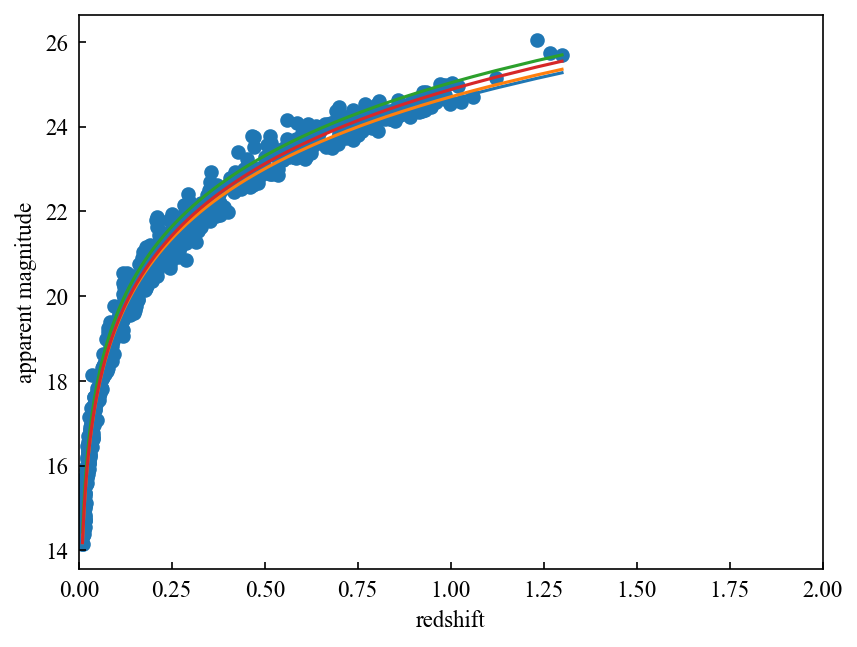

In [23]:
# read vectors of redshifts, apparent magnitude in B-band, mB, and its uncertainty emB:
zsn, msn, emsn = read_jla_data(sn_list_name = 'https://astro.uchicago.edu/~andrey/classes/a211/data/jla_lcparams.txt')
nsn = np.size(zsn)
print("read sample of %d supernovae..."%(nsn))

plt.scatter(zsn, msn)

def graph_redshift(zsn, M, H0, Om0, Oml):
    mpred = np.zeros(len(zsn))
    for i in range(0, len(zsn)): 
        mpred[i] += M + 5*np.log10(d_l(zsn[i], H0, Om0, Oml)) + 25
        mpred_sort = np.sort(mpred)
        zsn_sort = np.sort(zsn)
    plt.plot(zsn_sort, mpred_sort)
    
graph_redshift(zsn, -19, 70, .8, .2)
graph_redshift(zsn, -19, 70, .7, .3)
graph_redshift(zsn, -18.75, 70, .6, .4)
graph_redshift(zsn, -19, 70, .5, .5)
plt.xlabel('redshift')
plt.ylabel('apparent magnitude')
plt.xlim(0, 2)
#the line that fit best seemed to be the one with M = -19, Om0 = .5 and Oml=.5
#which in my plot is the red line
#generally, there is a positive relationship between redshift and magnitude
#which makes sense because a larger magnitude means a smaller brightness 
#and a larger redshift means a larger distance away and thus also a smaller brightness. 

### <font color='blue'>Exercise 4 (5 points): Using the inverse transform method</font>
    
to sample random numbers from the distribution $g(x)=A/\sqrt{x}$ for $x\in[1/a,a]$ where $a$ is a constant and $A$ is normalization constant.

**Task 4a (1 point).** Derive expression for the normalization constant $A$. 

**Task 4b (1 point).** Derive the expression for the cdf $P(x)$ and its inverse $x = P^{-1}(y)$, where $y$ is value in the range $[0,1]$. 

**Task 4c (3 points).** Assuming $a=2$ write code to draw random numbers using inverse transform method using the inverse cdf you derive to draw $10^6$ random numbers that follow pdf $g(x)$. Test your results by histogramming results and comparing the histogram to the analytic expression for $g(x)$ shown as a line. 

***Note:*** examples of how to do the steps required in the ITS method can be found in [Section 7.4](https://astro.uchicago.edu/~andrey/classes/a211w25/html/mc/sample1.html) of the notes and in the [04_mc_methods](https://drive.google.com/file/d/1AsHf8nY03fE77cLrzZadRjvp0IgOIe5o/view?usp=sharing) notebook. In the latter notebook it is also shown how to compare histogram of the random numbers to the pdf from which they are supposed to be sampled using function `plot_pdf` that can be found in the [`codes/plotting.py` file](https://drive.google.com/file/d/189lPhb0tcVQKekzQ_X7nuYs-pkukPOum/view?usp=sharing).

Part 1: 

To be Normalized, we need $\int\limits_\frac{1}{a}^a \frac{a}{\sqrt{x}}$ to integrate to 1, as that is the definition of a probability density function:

$$
1 = \int\limits_\frac{1}{a}^a \frac{a}{\sqrt{x}}\\
= 2A\sqrt{x}_\frac{1}{a}^a\\
=  2A\sqrt{a}-\frac{2A}{\sqrt{a}}\\
= A*(2\sqrt{a}-\frac{2}{\sqrt{a}})\\
A = \frac{1}{2\sqrt{a}-\frac{2}{\sqrt{a}}}
= \frac{\sqrt{a}}{2a-2}
$$

Part 2: 

We know that $\frac{d}{dx}(cdf) = pdf$, thus the cdf is the integral of the pdf for the lower limit ($\frac{1}{a}$) and whatever x value we are currently at: 
$$
cdf = \int\limits_\frac{1}{a}^x\frac{a}{\sqrt{x}}\\
= 2A\sqrt{x}_\frac{1}{a}^x\\
= 2A(\sqrt{x}-\frac{1}{\sqrt{a}}) = y
$$

Thus our inverse cdf x(y) is: 

$$
y = 2A(\sqrt{x}-\frac{1}{\sqrt{a}})\\
y + 2A\frac{1}{\sqrt{a}} = 2A\sqrt{x}\\ 
(y + \frac{2A}{\sqrt{a}})^2 = 4A^2x\\
x = \frac{(y + \frac{2A}{\sqrt{a}})^2}{4A^2}
$$

now subbing in for y in terms of a, we get: 

$$
x(y) = \frac{(y + \frac{2A}{\sqrt{a}})^2}{4A^2}
= \frac{(y + \frac{\frac{2\sqrt{a}}{2a-2}}{\sqrt{a}})^2}{4(\frac{\sqrt{a}}{2a-2})^2}
= \frac{(y + \frac{\frac{\sqrt{a}}{a-1}}{\sqrt{a}})^2}{\frac{a}{(a-1)^2}}
$$

finally, since we know that a = 2: 

$$
x(y) = \frac{(y + \frac{\frac{\sqrt{a}}{a-1}}{\sqrt{a}})^2}{\frac{a}{(a-1)^2}}
= \frac{(y + \frac{\frac{\sqrt{2}}{2-1}}{\sqrt{2}})^2}{\frac{2}{(2-1)^2}}
= \frac{(y + \frac{\frac{\sqrt{2}}{1}}{\sqrt{2}})^2}{2}
= \frac{(y+1)^2}{2}
$$


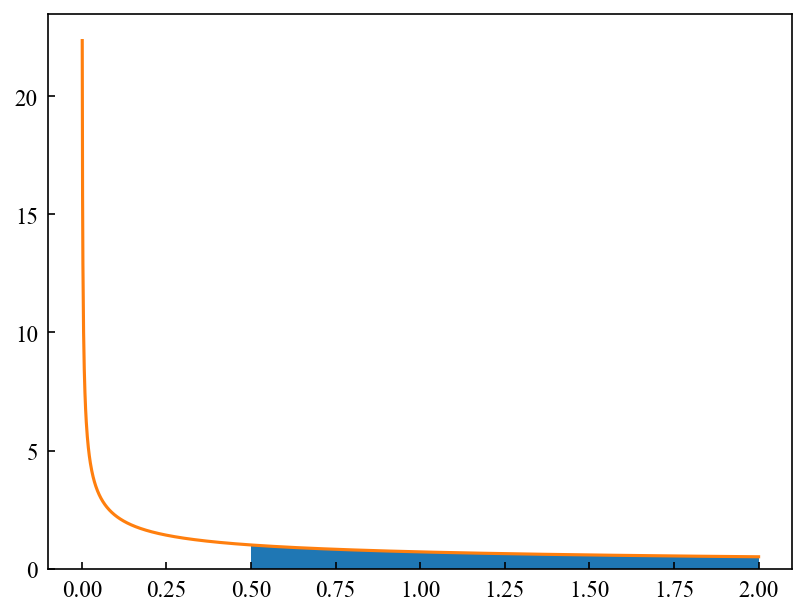

In [24]:

#Now that we have our inverse cdf, we just need to do part 3, the graphing
y = np.random.uniform(0, 1, 1000000) #choose this range of y to follow pdf on desired range.

x = 1/2 * (y+1)**2 

plt.hist(x, bins = 'auto', density = 'True')

x1 = np.arange(2000)+1 #add one so we are not dividing by 0 in the following steps. 
x1 = x1/1000
pdf = (np.sqrt(2)/2)*1/(np.sqrt(x1))
plt.plot(x1, pdf)

#the pdf pretty much perfectly follows the inverse cdf histogram 
#for our domain (1/2, 2), so the method seems to be working!
